# Sinusoid Regression: 1-step updates
Notebook to run experiments on the sinusoid dataset.

Before running this notebook, you need to run the MAML, Reptile, and MetaSGD pretraining runs:
`python tsfewshot/run_scheduler.py train --directory experiments/sinusoid/configs/ --runs-per-gpu 4 --gpu-ids 0`

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import pickle
import shutil
import sys
import os
from collections import defaultdict
from pathlib import Path

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import scipy
import torch
from matplotlib import rc
from scipy.stats import wilcoxon
from tqdm import tqdm

sys.path.append('../..')
from tsfewshot.config import Config
from tsfewshot import plot, analyses
from tsfewshot.pcautils import get_best_epoch

np.random.seed(0)
torch.random.manual_seed(0)

DEVICE = 'cuda:0'
SUPPORT_SIZES = [5, 10, 20]
QUERY_SIZE = 100
MODEL_SIZE = 1761  # number of parameters in the 2-hidden-layer model

CODE_DIR = Path('../..')

rc('text', usetex=True)

In [36]:
# get the run directories from the meta-training phase
RUNS = {support: {'maml': list(Path('runs/').glob(f'*maml-{support}support*'))[0].resolve(),
                  'metasgd': list(Path('runs/').glob(f'*metasgd-{support}support*'))[0].resolve()}
        for support in SUPPORT_SIZES}
RUNS[5]['reptile'] = Path('runs/sinusoid-reptile-5support25batch10steplr1.0innerlr0.005-finetune10-seed0_220304_233419')
RUNS[10]['reptile'] = Path('runs/sinusoid-reptile-10support25batch10steplr1.0innerlr0.005-finetune10-seed0_220305_095203')
RUNS[20]['reptile'] = Path('runs/sinusoid-reptile-20support25batch10steplr1.0innerlr0.01-finetune10-seed0_220305_050308')

In [42]:
ft_epochs = defaultdict(lambda: 1)
eval_every = [1]
inner_seeds = [0]

type_specs = [
    'normal',  # SGD finetuning based on MAML initialization. Effectively, this is MAML.
    'normal-metasgd',  # finetuning of the MetaSGD initialization
    'normal-reptile',  # finetuning of the Reptile initialization
    'pca',  # our method
]

gridsearch_dir = 'optimizeFinetune_fixedsteps'
test_tasks = ['0.1#5.0#0.0#3.141592654#-5.0#5.0']

def combinations(support, baseline=None):
    combinations = []
    for type_spec in type_specs:
        if (baseline is not None and baseline not in type_spec) or (baseline is None and type_spec not in ['normal', 'pca']):
            continue
        if type_spec == 'normal-metasgd':
            lrs = [2.0, 1.5, 1.0, 0.5, 0.1, 0.05, 0.01]
        elif type_spec == 'normal-reptile':
            lrs = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
        else:
            lrs = [2.0, 1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005]
        for lr in lrs:
            combinations.append({'support': support,
                                 'lr': lr,
                                 'type': type_spec,
                                 'noise': 0.0,
                                 'sparsity': None,
                                })
    return combinations
    
len(combinations(5))

18

In [43]:
# create gridsearch for optimal learning rate and number of update steps during finetuning.
new_runs = []
cfg_update = {
    'batch_size': 64,
    'training_setup': 'supervised',
}
for support in SUPPORT_SIZES:
    new_runs += analyses.create_gridsearch_dirs(RUNS[support]['maml'],
                                                combinations(support),
                                                gridsearch_dir,
                                                inner_seeds,
                                                n_trajectories=-1,
                                                query_size=QUERY_SIZE,
                                                ft_epochs=ft_epochs,
                                                eval_every=eval_every,
                                                save_predictions=False,
                                                optimizer='sgd-squared',
                                                val_datasets=test_tasks,
                                                n_dataset_evals=200,
                                                init_epoch=50000,
                                                tasks_ds_cfg=cfg_update,
                                                pca_file_path=RUNS[support]['maml'] / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse.p')
    for method in ['metasgd', 'reptile']:
        new_runs += analyses.create_gridsearch_dirs(RUNS[support][method],
                                                    combinations(support, baseline=method),
                                                    gridsearch_dir,
                                                    inner_seeds,
                                                    n_trajectories=-1,
                                                    query_size=QUERY_SIZE,
                                                    ft_epochs=ft_epochs,
                                                    eval_every=eval_every,
                                                    save_predictions=False,
                                                    optimizer='sgd',
                                                    val_datasets=test_tasks,
                                                    n_dataset_evals=200,
                                                    tasks_ds_cfg={'batch_size': 64},
                                                    init_epoch=50000 if method == 'metasgd' else None)

100%|██████████| 8/8 [00:00<00:00, 163.49it/s]


Next, run the created gridsearch configurations via:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_fixedsteps/ --epoch 50000 --split val --gpu-ids 0 --runs-per-gpu 5`. You need to do this for each pretraining run (MAML/MetaSGD/Reptile) of each support size.

In [45]:
methods = ['maml', 'metasgd', 'reptile']
best_ft_options = {m: {} for m in methods}
best_ft_epochs = {m: {} for m in methods}
gridsearch_results = {m: {} for m in methods}

In [46]:
# load the gridsearch results and calculate the best learning rate and number of update steps
# for each support size and each method.
# For the best configuration of each support size and method, we create a final finetuning experiment
# that we'll use to analyze the results.
new_run_dirs = []
for support in SUPPORT_SIZES:
    for method in methods:
        run = RUNS[support][method]
        out = analyses.create_final_finetune_dirs([run],
                                                  [support],
                                                  combinations(support, baseline=method if method != 'maml' else None),
                                                  [1],
                                                  gridsearch_dir,
                                                  test_tasks,
                                                  gridsearch_seeds=inner_seeds,
                                                  n_dataset_evals=100,
                                                  best_ft_options=best_ft_options[method],
                                                  best_ft_epochs=best_ft_epochs[method],
                                                  n_results=200,
                                                  metric_aggregation='mean',
                                                  metric_name='mse')
        new_run_dirs += out[0]
        best_ft_options[method].update(out[1])
        best_ft_epochs[method].update(out[2])
        gridsearch_results[method].update(out[3])
[r.name for r in new_run_dirs]

5
support size: 5    normal noise 0.0                                                                 LR: 0.01   epochs: 1    
support size: 5    pca noise 0.0                                                                    LR: 0.5    epochs: 1    
5
support size: 5    normal-metasgd noise 0.0                                                         LR: 1.0    epochs: 1    
5
support size: 5    normal-reptile noise 0.0                                                         LR: 0.005  epochs: 1    
10
support size: 5    normal noise 0.0                                                                 LR: 0.01   epochs: 1    
support size: 5    pca noise 0.0                                                                    LR: 0.5    epochs: 1    
support size: 10   normal noise 0.0                                                                 LR: 0.01   epochs: 1    
support size: 10   pca noise 0.0                                                                    LR: 0.25   epoch

['support5_lr0.005_normal-reptile_sparseNone_noise0.0_seed1',
 'support10_lr0.005_normal-reptile_sparseNone_noise0.0_seed1',
 'support20_lr0.01_normal-reptile_sparseNone_noise0.0_seed1']

Next, run the final finetuning experiments in each pretraining run:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_fixedsteps_finalFinetune/ --epoch 50000 --split test --gpu-ids 0 --runs-per-gpu 5`.

In [47]:
# load the result from final finetuning
metrics = None
for support in SUPPORT_SIZES:
    for method in ['maml', 'metasgd', 'reptile']:
        run = RUNS[support][method]
        init_epoch = 50000 if method != 'reptile' else None
        metrics = analyses.get_final_metrics([run],
                                             noises=[0.0],
                                             support_sizes=[support],
                                             combinations=combinations(support, baseline=method if method != 'maml' else None),
                                             best_ft_options=best_ft_options[method],
                                             inner_seeds=[1],
                                             query_size=QUERY_SIZE,
                                             n_trajectories=-1,
                                             test_tasks=test_tasks,
                                             gridsearch_dir=gridsearch_dir,
                                             init_epoch=init_epoch,
                                             metrics=metrics,
                                             metric_name='mse',
                                             metric_file_name='mse',
                                             metric_aggregation='mean',
                                             no_ft_eval=False)

5
5
5
10
10
10
20
20
20


In [55]:
# add MT-net and Meta-Curvature results
# for this to work, you need to run MT-Net and Meta-Curvature runs with their codebase
# and copy the pickle files to the specified directories.
first_key = list(metrics[0.0].keys())[0]
for support in SUPPORT_SIZES:
    mt_dir = CODE_DIR / f'../MT-net/logs/sine/cls_5.mbs_4.ubs_{support}.numstep1.updatelr0.01.temp1.0MTnetnonorm'
    mt_results = pickle.load(list(mt_dir.glob(f'*stepsize0.01*final.pkl'))[0].open('rb'))
    metrics[0.0][(support, 'normal mt-net', (f'mt-net-{support}support', 1))] = pd.DataFrame({'mse': mt_results['mses'][:, 1]}, index=metrics[0.0][first_key].index)
    
    mc_dir = Path('./meta-curvature/one-step')
    mc_results = pickle.load(list(mc_dir.glob(f'*ubs{support}_stepsize*.pkl'))[0].open('rb'))
    metrics[0.0][(support, 'normal metacurvature', (f'metacurvature-{support}support', 1))] = pd.DataFrame({'mse': mc_results['mses'][:, 1]}, index=metrics[0.0][first_key].index)

In [61]:
# dump results so we don't have to recalculate each time we run this notebook
pickle.dump(metrics, (RUNS[SUPPORT_SIZES[0]]['maml'] / 'metrics_fixedsteps.p').open('wb'))
pickle.dump(best_ft_options, (RUNS[SUPPORT_SIZES[0]]['maml'] / 'best_ft_options_fixedsteps.p').open('wb'))
pickle.dump(best_ft_epochs, (RUNS[SUPPORT_SIZES[0]]['maml'] / 'best_ft_epochs_fixedsteps.p').open('wb'))

In [53]:
df_norms = pd.DataFrame({k: v['mse'] for k, v in metrics[0.0].items()}, dtype=float)
df_norms.columns.names = ['support', 'type', 'seed']

# results table
display_df = df_norms.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).mean(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().sort_index(axis=1).style.background_gradient('Greens_r', axis=1).highlight_null('white'))

python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


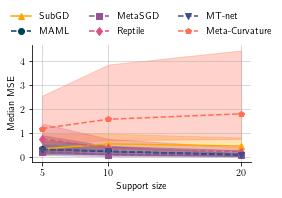

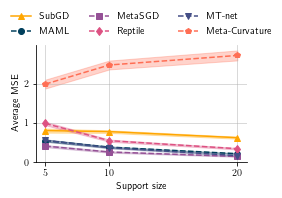

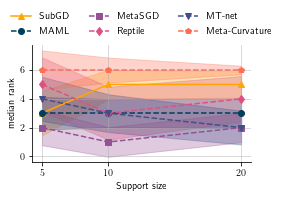

In [54]:
# plot results
figsize = (4, 3)
style = {
    'normal noise 0.0 ': {'ls': '--', 'col': '#003f5c', 'marker': 'o', 'label': 'MAML'},
    'normal-metasgd noise 0.0 ': {'ls': '--', 'col': '#955196', 'marker': 's', 'label': 'MetaSGD'},
    'normal mt-net': {'ls': '--', 'col': '#444e86', 'marker': 'v', 'label': 'MT-net'},
    'normal metacurvature': {'ls': '--', 'col': '#ff6e54', 'marker': 'p', 'label': 'Meta-Curvature'},
    'normal-reptile noise 0.0 ': {'ls': '--', 'col': '#dd5182', 'marker': 'd', 'label': 'Reptile'},
    'pca noise 0.0 ': {'ls': '-', 'col': '#ffa600', 'marker': '^', 'label': 'SubGD'},
}
exclude = [t for t in df_norms.columns.get_level_values("type") if 'no-pretrain' in t or 'supervised-pretrain' in t]
f = plot.plot_support_vs_mse(df_norms,
                             SUPPORT_SIZES,
                             ranks=False,
                             figsize=figsize,
                             aggregation='median',
                             style=style,
                             alpha=0.3,
                             exclude_types=exclude,
                             metric_name='MSE')
f1 = plot.plot_support_vs_mse(df_norms,
                             SUPPORT_SIZES,
                             ranks=False,
                             aggregation='mean',
                             figsize=figsize,
                             exclude_types=exclude,
                             alpha=0.3,
                             style=style,
                             metric_name='MSE')
f1.savefig('plots/sinusoid-support-vs-mse-mean-fixedsteps.pdf', bbox_inches='tight')
f2 = plot.plot_support_vs_mse(df_norms,
                              SUPPORT_SIZES,
                              ranks=True,
                              alpha=0.3,
                              exclude_types=exclude,
                              figsize=figsize,
                              style=style)

In [56]:
# significance test
p = {}
noise = 0.0
sig_df = df_norms.groupby(['support', 'type'], axis=1).agg(lambda s: s.mean(skipna=False))
best_typs = {support: sig_df.loc[:, support].mean().idxmin(axis=1) for support in SUPPORT_SIZES}
for support, typ in sig_df.columns:
    if typ == f'{best_typs[support]} noise 0.0 ':
        p[(support, typ)] = np.nan
        continue
    if ((sig_df.loc[:, (support, typ)] - sig_df.loc[:, (support, best_typs[support])]) == 0).all():
        p[(support, typ)] = np.nan
        continue
    p[(support, typ)] = wilcoxon(sig_df.loc[:, (support, typ)], sig_df.loc[:, (support, best_typs[support])])[1]
sig_df = pd.DataFrame(p, index=['p-value']).T
sig_df.index.names = ['support', 'type']
display(sig_df.reset_index().pivot(index='type', columns='support', values='p-value').style.format('{:.3e}'))

support,5,10,20
type,,,
normal metacurvature,nan,nan,nan
normal mt-net,7.398e-15,9.602e-18,3.897e-18
normal noise 0.0,1.754e-14,5.596e-18,3.897e-18
normal-metasgd noise 0.0,2.844e-16,4.016e-18,3.897e-18
normal-reptile noise 0.0,1.512e-04,1.558e-12,3.781e-16
pca noise 0.0,2.996e-10,1.167e-15,3.897e-18
